# Supervised Classification
This jupyter notebook contains the code and a report on the usage of different classification methods to predict categories on the UCI Machine Learning dataset "Teacher Assistant Evaluation".

The work contained within is created by: <br>
Sharon Ramírez   - A01379035 <br>
Andrea Gonzáles  - A01176527 <br>
Yareth Lafarge   - A00835326 <br>
Rafael Martínez  - A01274853 <br>

The Teacher Assistant Dataset contains 151 entries with 5 attributes each, categorizing an entry into one of three categories:<br>
1 - Low<br>
2 - Medium<br>
3 - High<br>

We use three different classifiers in order to characterize this dataset:
1. Decision Trees: A method based on binary decisions in order to reach a conclusion about what category an entry belongs to.
2. kNN: A method based on the similarity of entries to their neighbors, classifying data points based on what is near them.
3. LDA: A linear boundary based method that sets a threshold with which to separate entries into different categories.

## Basic Imports and Dataset Loading
For this work, Pandas will be used for data handling, and numpy for most mathematical operations. Additional imports will be used depending on each classifier, but they will be explained in their own sections.

We load the dataset as a Pandas dataframe. The .data file does not contain headers, so we add our own to allow for easier visualization. Here is a short description of each attribute:
- English? - Whether the TA is a native english speaker. 1 = Yes. 2 = No.
- Instructor - A number identifying the instructor, it is a generic category.
- Course - A number identifying the course, it is a generic category.
- Summer? - Whether the course was taught as a summer or regular class. 1 = Yes. 2 = No.
- Class Size - A number corresponding to the size of the class.
- Quality - The score of the TA, divided into one of three. 1 = Low. 2 = Medium. 3 = High.

In [11]:
#Basic imports
import pandas as pd
import numpy as np

#Database import
teacher_dataset=pd.read_csv('tae.data',names=["English?","Instructor","Course","Summer?","Class Size","Quality"])
print(teacher_dataset)

     English?  Instructor  Course  Summer?  Class Size  Quality
0           1          23       3        1          19        3
1           2          15       3        1          17        3
2           1          23       3        2          49        3
3           1           5       2        2          33        3
4           2           7      11        2          55        3
..        ...         ...     ...      ...         ...      ...
146         2           3       2        2          26        1
147         2          10       3        2          12        1
148         1          18       7        2          48        1
149         2          22       1        2          51        1
150         2           2      10        2          27        1

[151 rows x 6 columns]


## Decision Trees
Decisions trees are based on dividing categories into a flowchart that allows one decision to lead to the other consecutively, until we eventually reach a conclusion. 

For this work, two things will be shown:
- A step-by-step construction of the first level of the decision tree using the full dataset for didactic purposes.
- A Scikit Learn trained model using an 80/20 split for training/testing.

### Manual Approach
Scikit Learn includes a module for generating and training a decision, but first we will explain step-by-step how the construction of such an algorith is made, in order to justify the use of this technique for classification.

### Entropy
For the optimal construction of a decision tree, it is important to know how much information is given by each attribute, as to decide the level at which each should be. 

To determine what the level of information gained is, we use the Shannon model. Note that usually for binary decision trees we would see a range of 0 to 1 for information gain (at most, we gain a bit of information corresponding to a binary decision), but this is trinary tree: We have three possible outcomes. As such, information gains can be greater than 1.

Determining the entropy of an attribute, that is, how 'disordered' it is and therefore how much information we can gain by ordering it, we use the following equation:

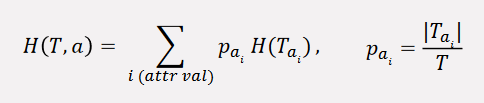

Where H(T,a) is the entropy for a particular attribute, a, for a certain number of counts, T. p is the 'probability', which is the observed amount of counts for each partition of an attribute (Ta) divided by the total number of counts. To calculate H(Ta) we use the sum of each Shannon information gain per partition:

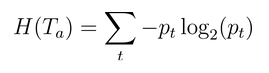

Each 't' is an entry for that partition.

We create a function that calculates the entropy for any attribute for a generic dataframe. It does the following:
- Groups the dataframe by that attribute
- Calculates the total number of entries
- Calculates the size of each partition for that attribute
- Calculates the information per partition
- Calculates the entropy per partition
- Sums the entropies and returns them

In [12]:
## INPUT: Dataframe, attribute and category as string
## OUTPUT: Entropy, as a number, and the dataframe with all the calculation data
def entropy(dataframe, attribute, category):
    dfaux = dataframe.groupby([attribute, category], as_index=False).size()
    df = dataframe.groupby([attribute], as_index=False).size()
    count = dfaux["size"].sum()
    
    # Get total size for each category
    df = df.rename(columns={"size":"total"})
    dfaux = pd.merge(dfaux, df, how="left", on=attribute)
    
    # Calculate information per row
    dfaux["info"]=-(dfaux["size"]/dfaux["total"])*np.log2(dfaux["size"]/dfaux["total"])
    
    # Calculate entropy
    dfaux = dfaux.groupby([attribute],as_index=False).sum()
    dfaux["entropy"] = dfaux["info"]*(dfaux["size"]/count)
    entropy = dfaux["entropy"].sum()
    
    return entropy, dfaux


In [13]:
[entropyE,t] = entropy(teacher_dataset,"English?","Quality")
[entropyI,t] = entropy(teacher_dataset,"Instructor","Quality")
[entropyC,t1] = entropy(teacher_dataset,"Course","Quality")
[entropyS,t] = entropy(teacher_dataset,"Summer?","Quality")
[entropyCS,t] = entropy(teacher_dataset,"Class Size","Quality")


## Print entropies:
print("Total Entropies per Attribute:")
print("==============================================")
print("Course in English? -- "+str(entropyE))
print("Instructor         -- "+str(entropyI))
print("Course             -- "+str(entropyC))
print("Summer Course?     -- "+str(entropyS))
print("Size of class      -- "+str(entropyCS))

Total Entropies per Attribute:
Course in English? -- 1.5288054271129314
Instructor         -- 1.180139907706205
Course             -- 1.150869239749956
Summer Course?     -- 1.5225056243291086
Size of class      -- 0.764631679828438


Now, to decide which attribute to put as root, we choose the highest information gain by substracting each entropy from the general entropy:

In [14]:
## General entropy
qualitas = teacher_dataset.groupby(["Quality"], as_index=False).size()
genEnt = -(qualitas.iloc[0,1]/151)*np.log2(qualitas.iloc[0,1]/151)-(qualitas.iloc[1,1]/151)*np.log2(qualitas.iloc[1,1]/151)-(qualitas.iloc[2,1]/151)*np.log2(qualitas.iloc[2,1]/151)

print("General Entropy:")
print(genEnt)
print("")

## Information Gain
print("Information Gain per Attribute:")
print("==========================================")
print("Course in English? -- "+str(genEnt-entropyE))
print("Instructor         -- "+str(genEnt-entropyI))
print("Course             -- "+str(genEnt-entropyC))
print("Summer Course?     -- "+str(genEnt-entropyS))
print("Size of class      -- "+str(genEnt-entropyCS))

General Entropy:
1.5845209168501235

Information Gain per Attribute:
Course in English? -- 0.05571548973719209
Instructor         -- 0.4043810091439186
Course             -- 0.4336516771001675
Summer Course?     -- 0.0620152925210149
Size of class      -- 0.8198892370216855


## Iterating to find next levels

Our root is **size of class**. This attribute has a lot of values that immediately determine the quality of the class. We will first determine the leaves, which is what attributes cause the tree to be immediately finalized -- we do this by checking where we have entropy 0:

In [15]:
## INPUT: A dataframe, the attribute's name, and a trinary category
def findLeaves(dataframe, attribute, category="Quality"):
    df = dataframe.groupby([attribute], as_index=False).count()
    df = df[attribute]
    leaves = []
    subtables = []
    for i in df:
        dfaux = teacher_dataset.query("`"+str(attribute)+"` == "+str(i))
        [x, t] = entropy(dfaux, attribute, category)
        if  x == 0:
            leaves.append(i)
        else:
            subtables.append(dfaux)
    return leaves, subtables

[leaves, subtables] = findLeaves(teacher_dataset, "Class Size")


Here is what is found after looking for leaves, and some of the resulting subtables.

In [16]:
print("Leaves:")
print(leaves)
print("A sampling of some subtables:")
print(subtables[0])
print(subtables[5])

Leaves:
[3, 5, 7, 9, 12, 16, 18, 22, 26, 28, 32, 33, 34, 35, 39, 43, 44, 45, 46, 48, 49, 51, 54, 55, 58, 66]
A sampling of some subtables:
     English?  Instructor  Course  Summer?  Class Size  Quality
16          2           7      11        2          10        2
18          2          13       3        1          10        2
55          2           7      11        2          10        2
57          2          13       3        1          10        2
106         2          23       3        2          10        2
144         2          19       4        2          10        1
     English?  Instructor  Course  Summer?  Class Size  Quality
1           2          15       3        1          17        3
40          2          15       3        1          17        3
79          1          13       3        1          17        3
89          2          14      22        2          17        3
121         2          13      14        2          17        3
132         2          14    

We now will continue to split it, using the next best attribute (by checking info gain) for each branch.

In [17]:
for i in range(0, len(subtables)):
    df = subtables[i]
    classSize = df.iloc[0,4]
    df = df.drop(columns=["Class Size"])
    [entropyE,t] = entropy(teacher_dataset,"English?","Quality")
    [entropyI,t] = entropy(teacher_dataset,"Instructor","Quality")
    [entropyC,t1] = entropy(teacher_dataset,"Course","Quality")
    [entropyS,t] = entropy(teacher_dataset,"Summer?","Quality")
    qualitas = df.groupby(["Quality"], as_index=False).size()
    size = qualitas.shape
    size = size[0]
    genEnt = 0
    try:
        genEnt = -(qualitas.iloc[0,1]/size)*np.log2(qualitas.iloc[0,1]/size)
    except IndexError:
        pass
    try:
        genEnt += -(qualitas.iloc[1,1]/size)*np.log2(qualitas.iloc[1,1]/size)
    except IndexError:
        pass
    try:
        genEnt += -(qualitas.iloc[2,1]/size)*np.log2(qualitas.iloc[2,1]/size)
    except IndexError:
        pass
    ordered = np.array([("English?", genEnt - entropyE),
                        ("Instructor",genEnt - entropyI),
                        ("Course",genEnt - entropyC),
                        ("Summer?",genEnt - entropyS)], dtype=[("x","S10"),("y", float)])
    ordered.sort(order="y")
    best = ordered[-1][0]
    best = best.decode("utf-8")
    
    print("For branch Class Size = "+str(classSize)+", the best category is "+str(best))
    if genEnt == 0:
        print("->Additionally, it's homogenous!")

For branch Class Size = 10, the best category is Course
For branch Class Size = 11, the best category is Course
For branch Class Size = 13, the best category is Course
->Additionally, it's homogenous!
For branch Class Size = 14, the best category is Course
For branch Class Size = 15, the best category is Course
For branch Class Size = 17, the best category is Course
For branch Class Size = 19, the best category is Course
For branch Class Size = 20, the best category is Course
For branch Class Size = 21, the best category is Course
For branch Class Size = 23, the best category is Course
For branch Class Size = 24, the best category is Course
For branch Class Size = 25, the best category is Course
For branch Class Size = 27, the best category is Course
For branch Class Size = 29, the best category is Course
For branch Class Size = 30, the best category is Course
->Additionally, it's homogenous!
For branch Class Size = 31, the best category is Course
For branch Class Size = 36, the best c

## Scikit Learn -- Training a decision tree
First, we import the required libraries to build the tree.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set()

RANDOM_STATE = 10

As stated before, our classification attribute is Quality which will be denoted by the variable "Y".
The test set will be randomly chosen from the complete dataset. 

In [19]:
X = teacher_dataset[["English?","Instructor","Course","Summer?","Class Size"]]
Y = teacher_dataset["Quality"]

from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
Y = labelEncoder.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

The criteria to build the tree is defined by the entropy. It is produced a cross validation to evaluate the performance of the classifier.

In [20]:
from sklearn import tree
from sklearn.model_selection import cross_val_score


clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=RANDOM_STATE)



cross_val_score(clf, X_train, y_train, cv=5)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

predicted = clf.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.60      0.90      0.72        10
           2       0.67      0.60      0.63        10

    accuracy                           0.68        31
   macro avg       0.71      0.68      0.67        31
weighted avg       0.71      0.68      0.67        31



In [21]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Teacher")

'Teacher.pdf'

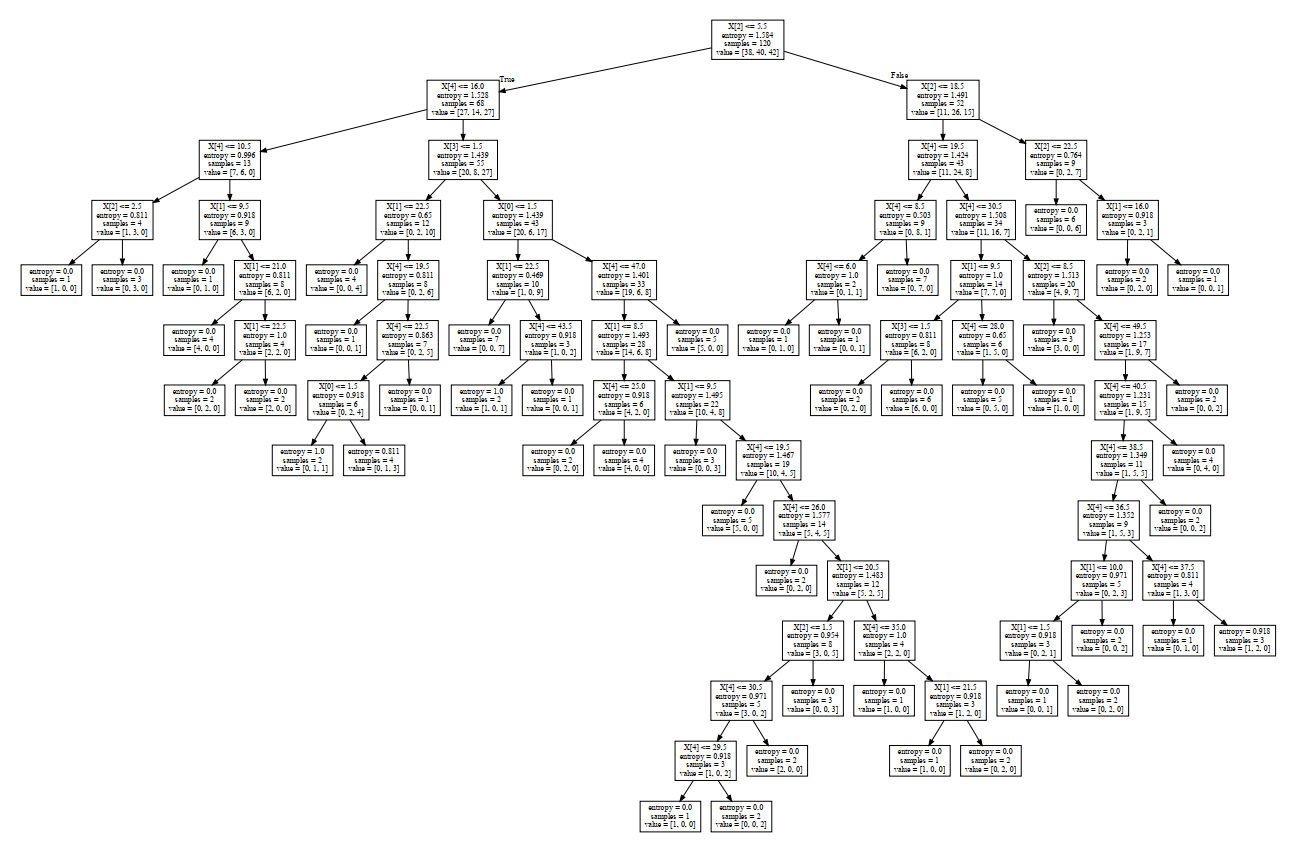

It can be observed that the root class is X[2] that corresponds to the course and against the manual approach it is different. We attribute this to the split of the training and testing set, therefore the entropy changes due to the reduction of the size regarding the training set.

From here, we can continue checking each level iteratively. For this, we will use Scikit Learn's Decision Tree model using an 80/20 split of data for training and testing.

## k-Nearest Neighbors (k-NN)

K-NN is a classification clustering method. This method is one of the simplest learning algorithms for data classification. When a test sample is provided to the algorithm for class prediction, it uses a majority vote of the k nearest (neighboring) points to determine the corresponding class. This makes the method more robust against outliers or mislabeled data.

This method is of interest to us due to its simplicity. It allows for a 'benchmark' of how difficult the dataset is, and is a good comparison point for more complex methods (such as our decision tree).

In [22]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import neighbors, datasets


tae_data = pd.read_csv('tae.data',header=None,  names=["English speaker", "Course instructor", "Course", "Semester", "Size", "Attribute"])
tae_data

,English speaker,Course instructor,Course,Semester,Size,Attribute
0,1,23,3,1,19,3
1,2,15,3,1,17,3
2,1,23,3,2,49,3
3,1,5,2,2,33,3
4,2,7,11,2,55,3
...,...,...,...,...,...,...
146,2,3,2,2,26,1
147,2,10,3,2,12,1
148,1,18,7,2,48,1
149,2,22,1,2,51,1


The first step is to save all our attributes excluding the class attribute in one variable (X).

In [23]:
X = tae_data[tae_data.columns[:5]]
X

,English speaker,Course instructor,Course,Semester,Size
0,1,23,3,1,19
1,2,15,3,1,17
2,1,23,3,2,49
3,1,5,2,2,33
4,2,7,11,2,55
...,...,...,...,...,...
146,2,3,2,2,26
147,2,10,3,2,12
148,1,18,7,2,48
149,2,22,1,2,51


Then, the class attribute will also be stored in the variable that will be our target variable.

In [24]:
y = tae_data[tae_data.columns[5:6]]
y

,Attribute
0,3
1,3
2,3
3,3
4,3
...,...
146,1
147,1
148,1
149,1


In [25]:
y.values.ravel()

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

The train_test_split() function receives four arguments. The first argument is the array containing the features, the second argument is the array containing the target variable. The test_size argument is used to specify the amount of data to be split and stored in the test set. As we have specified 0.2, 20% of the original data will be stored in the test set, while 80% of the original data will be used for training. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.2,random_state=42, stratify=y.values.ravel())

The k-NN classifier is initialized with 4 neighbors. The .fit() method is used to fit this classifier to our training data. Finally, using the .score() method on the test data, we obtain a value between 0 and 1 indicating the accuracy of the classifier.

In [27]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.61
Accuracy of K-NN classifier on test set: 0.42


The predict method is used to predict the class labels for the data provided. Precision tells us how many of the actual positives were correctly predicted to be positive, recall tells us how many of the predicted positives were actually positive. The F1 score combines the two into a single number that can be used as a fair judge of the model and is equal to the harmonic mean of precision and recall. The value of the F1 score will always lie between 0 (if either precision or recall is zero) and 1 (if both precision and recall are 1). The higher the score, the better the model's performance is said to be. Finally, the support is the number of samples of the true response that lie in that class. The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). The precision and recall presented are not very good, but recall is better than precision, indicating that fraudulent cases were better predicted.

In [28]:
predicted = knn.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           1       0.42      0.50      0.45        10
           2       0.40      0.60      0.48        10
           3       0.50      0.18      0.27        11

    accuracy                           0.42        31
   macro avg       0.44      0.43      0.40        31
weighted avg       0.44      0.42      0.40        31



In [29]:
knn = KNeighborsClassifier(n_neighbors=4)
y_pred = cross_val_predict(knn, X, y.values.ravel(), cv=5)

In [30]:
y_pred

array([3, 3, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 3, 2, 2, 2, 2, 3, 1, 2, 2, 2,
       1, 1, 2, 2, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 3, 3, 1, 1,
       3, 1, 3, 3, 3, 3, 1, 3, 2, 2, 2, 2, 3, 1, 2, 1, 2, 1, 1, 2, 2, 3,
       2, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 2, 2, 1, 3, 3,
       1, 2, 2, 2, 3, 3, 2, 2, 3, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1, 1, 1,
       3, 1, 3, 3, 1, 2, 3, 1, 1, 3, 2, 2, 2, 1, 1, 1, 3, 2, 1, 1, 3, 1,
       3, 3, 1, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 2, 2, 1, 2, 2, 1],
      dtype=int64)

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

Mean square error is the mean square error of the difference between the actual and predicted values, the smaller the error the better the result. 

R2 is the correlation between the dependent variable and the set of independent variables, the higher the correlation the better the result.

In [32]:
print(mean_squared_error(y,y_pred))
print(r2_score(y,y_pred))

1.0463576158940397
-0.565280146962341


Using cross validation to find optimal number of neighbors. Using cross-validation ensures that we do not overfit or underfit the data as we have used the entire dataset for training and testing. k-Fold Cross Validation: Split the data into k folds, for k runs, use one fold as testing and the rest as training. Average over the k folds. 

In [33]:
error = []
for k in range(1,26):
    knn = KNeighborsClassifier(n_neighbors=k)
    y_pred = cross_val_predict(knn, X, y.values.ravel(), cv=5)
    error.append(mean_squared_error(y,y_pred)) 

In [34]:
import matplotlib.pyplot as plt

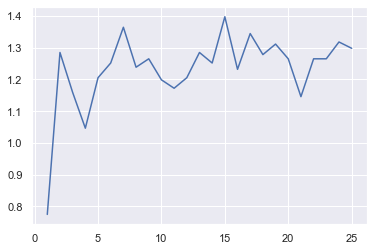

In [35]:
plt.plot(range(1,26),error)

As can be seen in the graph, the optimal number of neighbors is 4, since it presents the lowest error.

# Linear Discriminant Analysis (LDA)

LDA is a generalization of Fisher's linear discriminant, and it is a classifier used to find a linear combination of features that characterizes or separates two or more classes of data.  It has a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density function to each class, assuming that all classes share the same covariance matrix.

This method is of interest to us since it is a quick and simple method, but not quite as simple as a normal linear regression and completely different as kNN, as it uses a linear decision boundary instead of just close neighbors. This allows us to compare the two methods (neighbors vs decision boundaries) and check which one achieves better results.

First, we import some basic libraries and our database. 

In [36]:
#Basic imports
import pandas as pd
import numpy as np

#Database import
tae = pd.read_csv('tae.data',names=["English?","Instructor","Course","Summer?","Class Size","Quality"])
tae

,English?,Instructor,Course,Summer?,Class Size,Quality
0,1,23,3,1,19,3
1,2,15,3,1,17,3
2,1,23,3,2,49,3
3,1,5,2,2,33,3
4,2,7,11,2,55,3
...,...,...,...,...,...,...
146,2,3,2,2,26,1
147,2,10,3,2,12,1
148,1,18,7,2,48,1
149,2,22,1,2,51,1


We will also need some imports from Scikit-learn.

In [37]:
#Imports needed for LDA

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

We will now divide our data into two. X will be our data from all attributes except the last one, and y will be the rest of the data (the class attribute).

In [38]:
X = tae.iloc[:,:5]
X

,English?,Instructor,Course,Summer?,Class Size
0,1,23,3,1,19
1,2,15,3,1,17
2,1,23,3,2,49
3,1,5,2,2,33
4,2,7,11,2,55
...,...,...,...,...,...
146,2,3,2,2,26
147,2,10,3,2,12
148,1,18,7,2,48
149,2,22,1,2,51


In [39]:
y = tae.iloc[:,5:6]
y

,Quality
0,3
1,3
2,3
3,3
4,3
...,...
146,1
147,1
148,1
149,1


In [40]:
y = y.values.ravel()

We now split our data into a train set and a test set. The default parameters are 25% for the test set and the rest for training; however, we found that a 20/80 split resulted in a better accuracy. 

In [41]:
#Train-test splitting

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, train_size = 0.8, random_state = 0)

The LDA model is applied to the data and accuracy is calculated. Accuracy is the number of correct predictions (both positive and negative) among all cases examined. 

In [42]:
#Applying the LDA

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.55
Accuracy of LDA classifier on test set: 0.61


Precision, recall, f1 score and support are also calculated. 

Precision is also known as positive predictive value, and it is calculated as follows: tp / (tp + fp), where tp is the number of true positives and fp the number of false positives. It can be interpreted as the ability of the classifier not to label as positive a sample that is negative.

Recall or true positive rate is calculated as follows: tp / (tp + fn), where tp is the number of true positives and fn the number of false negatives. It can be interpreted as the ability of the classifier to find all the positive samples.

F1 score is a value calculated using both precision and recall as follows: (precision * recall) / (precision + recall)

Finally, support is the number of occurrences of each class in the correct target values. 

We can see that precision and recall have similar average values; but they vary between classes. 

In [43]:
#Calculating metrics 

predicted = lda.predict(X_test)
expected = y_test
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

           1       0.55      0.86      0.67         7
           2       0.71      0.42      0.53        12
           3       0.62      0.67      0.64        12

    accuracy                           0.61        31
   macro avg       0.63      0.65      0.61        31
weighted avg       0.64      0.61      0.60        31



## Conclusions
The first thing we noticed with all methods was that the accuracy was relatively low, with a maximum achieved at 68% with Decision Trees and a minimum of 42% with kNN. This tells us that the dataset is not so easily classified: There are many outliers, and complicated relations which make it hard for these relatively simple methods to describe with high certainty.

For decision trees, we noticed that the method was by far the most complex, with multiple rules for choosing, calculations needing to be done for tables, subtables, sub-subtables, etc, but it also achieved the best accuracy: With the same test/train split of 20/80 we achieved a 68% accuracy, being the best out of all the methods. 

With kNN we had the advantage of a simple method that decides differently from linear methods, thanks to its decisions being based on what the number of neighbors selected suggest rather than a set linear boundary. This, however, turned out to be not the best way to decide for this particular dataset, as the accuracy of 42% on the test set reveals. This means that the data is not easily characterized by its neighbors. The tests with other methods suggest that for this problem a linear decision boundary performs better than kNN.

With LDA we noticed that even though it is a much more straightforward method compared to decision trees it still achieved a similar performance at 61% accuracy with the same test/train split. Something we can keep in mind is that LDA performs best with a normal distribution of data, but we do not know if our dataset follows any particular arrangement which could account for the low accuracy, although it is still performing competitively compared to our original method.

While these methods achieve a better result than chance, and a 68% accuracy is significant, it is clear to us that other methods may be better for this particular dataset. The advantage of the methods used, however, is that they were very simple to implement using SciKit Learn, and it's a cheap and easy way to make predictions when no other methods are easily deployed.

### Sources
Jolly, K. (2018). Machine learning with scikit-learn quick start guide : Classification, regression, and clustering techniques in python. Packt Publishing, Limited.

Johnston, B., & Mathur, I. (2019). Applied supervised learning with python : Use scikit-learn to build predictive models from real-world datasets and prepare yourself for the future of machine learning. Packt Publishing, Limited.


Decision Trees - <br>
https://scikit-learn.org/stable/modules/tree.html <br>
https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

kNN - <br>
https://scikit-learn.org/stable/modules/neighbors.html

LDA - <br>
https://scikit-learn.org/0.16/modules/lda_qda.html